In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import math

from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, precision_recall_curve, matthews_corrcoef

from utils import *

In [2]:
# Set the matplotlib to make colorful plots
plt.style.use('ggplot')
plt.style.use('seaborn-poster')

<ipython-input-2-b8a539ca9e1e>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [3]:
drug_list1 = getDrugList('Walker')
drug_list2 = getDrugList('CRyPTIC')
drug_list = list(set(drug_list1) | set(drug_list2))
drug_dict = {key: value for (key, value) in zip(drug_list, drug_list)}
drug_dict['MOX'] = 'MXF'
drug_dict['AK'] = 'AMI'
drug_list_new = [drug_dict[drug] for drug in drug_list]
drug_dict

{'EMB': 'EMB',
 'OFX': 'OFX',
 'INH': 'INH',
 'KAN': 'KAN',
 'CAP': 'CAP',
 'MOX': 'MXF',
 'AMI': 'AMI',
 'RIF': 'RIF',
 'DLM': 'DLM',
 'SM': 'SM',
 'PZA': 'PZA',
 'ETH': 'ETH',
 'LZD': 'LZD',
 'RFB': 'RFB',
 'LEV': 'LEV',
 'BDQ': 'BDQ',
 'CFZ': 'CFZ',
 'CIP': 'CIP',
 'MXF': 'MXF',
 'AK': 'AMI'}

In [19]:
# Function to plot the ROC curve
def plotROC(dataset, drug, model_list):
    with open(f'../Results/single_binary_classification/{dataset}/{drug}_{model}.pkl', 'rb') as f:
        res = pickle.load(f)
    res_list, best_param_list = res

    test_logits_all, y_test_all = [], []
    for i in range(len(res_list)):
        train_logits, val_logits, test_logits, y_train, y_val, y_test = res_list[i]
        test_logits_all.extend(test_logits)
        y_test_all.extend(y_test)
    fpr, tpr, thresholds = roc_curve(y_test_all, test_logits_all)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.legend(loc="lower right")
    plt.show()



# Find the best threshold for classification by the Youden’s J statistic.
def find_thr(labels, preds):
    fpr, tpr, thresholds = roc_curve(labels, preds)
    best_thr = thresholds[np.argmax(tpr - fpr)]
    return best_thr


# Function to calculate the test results (mean + std)
def getBinaryResults(dataset, drug, model):
    with open(f'../Results/single_binary_classification/{dataset}/{drug}_{model}.pkl', 'rb') as f:
        res = pickle.load(f)
    res_list, best_param_list = res
    
    sen_list, spe_list, f1_list, mcc_list, auroc_list, auprc_list = [], [], [], [], [], []
    res_dict = {}
    for i in range(len(res_list)):
        train_logits, val_logits, test_logits, y_train, y_val, y_test = res_list[i]
        best_thr = find_thr(y_test, test_logits)
        y_pred = [1 if x >= best_thr else 0 for x in test_logits]
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sen = tp / (tp + fn)
        spe = tn / (tn + fp)
        f1 = 2 * tp / (2 * tp + fp + fn)
        mcc = matthews_corrcoef(y_test, y_pred)
        auroc = roc_auc_score(y_test, test_logits)
        precision, recall, _ = precision_recall_curve(y_test, test_logits)
        auprc = auc(recall, precision)

        sen_list.append(sen)
        spe_list.append(spe)
        f1_list.append(f1)
        mcc_list.append(mcc)
        auroc_list.append(auroc)
        auprc_list.append(auprc)

    res_dict['sen'] = (np.mean(sen_list), np.std(sen_list))
    res_dict['spe'] = (np.mean(spe_list), np.std(spe_list))
    res_dict['f1'] = (np.mean(f1_list), np.std(f1_list))
    res_dict['mcc'] = (np.mean(mcc_list), np.std(mcc_list))
    res_dict['auroc'] = (np.mean(auroc_list), np.std(auroc_list))
    res_dict['auprc'] = (np.mean(auprc_list), np.std(auprc_list))
    res_dict['num_exps'] = len(res_list)
    res_dict['sen_list'] = sen_list
    res_dict['spe_list'] = spe_list
    res_dict['f1_list'] = f1_list
    res_dict['mcc_list'] = mcc_list
    res_dict['auroc_list'] = auroc_list
    res_dict['auprc_list'] = auprc_list

    return res_dict


In [66]:
# Analysis the results of the MTB-HINE-BERT model
def binaryBarPlot(dataset, matrix):
    drug_list = getDrugList(dataset)
    # drug_list = ['INH', 'EMB', 'PZA', 'OFX', 'CAP', 'AK', 'KAN', 'MOX', 'CIP']
    model_list = ['nn', 'bert1_no_pretrained', 'bert1', 'bert1_no_freeze']
    model_name = {'lr': 'LR', 'rf': 'Random Forest', 'lr': 'LR', 'nn': 'NN', 'bert1': 'MTB-HINE-BERT', 'bert1_no_freeze': 'MTB-HINE-BERT (unfrozen)', 'bert1_no_pretrained': 'MTB-HINE-BERT (no pretrain)'}
    matrix_name = {'sen': 'Sensitivity', 'spe': 'Specificity', 'f1': 'F1-score', 'auroc': 'AUROC', 'mcc': 'MCC', 'auprc': 'AUPRC'}
    # group bar plot
    X_axis = np.arange(len(drug_list))
    res_dict = {}
    y_min = 1
    for model in model_list:
        res_dict[model] = {'mean': [], 'std': []}
        for drug in drug_list:
            mean_value, std_value = getBinaryResults(dataset, drug, model)[matrix]
            res_dict[model]['mean'].append(mean_value)
            res_dict[model]['std'].append(std_value)
            if mean_value < y_min:
                y_min = mean_value
            res_dict[(drug, model)] = getBinaryResults(dataset, drug, model)
    # let y_min be the smallest 0.1 multiple
    y_min = int(y_min * 10) / 10

    width = 0.15
    fig, ax = plt.subplots(figsize=(15, 5))
    for i, model in enumerate(model_list):
        ax.bar(X_axis + i * width, res_dict[model]['mean'], width, label=model_name[model])
    # plot the std as error bar with lowlims=True, don't show the arrow
    for i, model in enumerate(model_list):
        _, caplines, _ = ax.errorbar(X_axis + i * width, res_dict[model]['mean'], yerr=res_dict[model]['std'], fmt='none', ecolor='dimgray', capsize=2, capthick=1, elinewidth=2, lolims=True)
        caplines[0].set_marker('_')
    
    # Calculate the p-value between the best version of the model and the baseline model
    for drug in drug_list:
        res_list1 = res_dict[(drug, model_list[0])][matrix + '_list']
        mean2, std2, res_list2 = float('-inf'), float('inf'), []
        for model in model_list[1:]:
            mean, std = res_dict[(drug, model)][matrix]
            # when the mean is larger, update the best model
            if round(mean, 3) > round(mean2, 3):
                mean2 = mean
                std2 = std
                res_list2 = res_dict[(drug, model)][matrix + '_list']
            # when the mean is equal, update the best model with smaller std
            elif round(mean, 3) == round(mean2, 3) and round(std, 3) < round(std2, 3):
                mean2 = mean
                std2 = std
                res_list2 = res_dict[(drug, model)][matrix + '_list']
        _, p_value = stats.ttest_rel(res_list1, res_list2)
        res_dict[(drug, 'p_value')] = f"{p_value:.3f}" if p_value >= 0.001 else "<0.001"


    ax.set_ylim(ymin=y_min)
    ax.set_xlabel('Drug (p-value)')
    ax.set_ylabel(matrix_name[matrix])
    # show the p-value with the drug name on x-axis
    ax.set_xticks(X_axis + width)
    ax.set_xticklabels([f"{drug_dict[drug]}\n({res_dict[(drug, 'p_value')]})" for drug in drug_list])
    ax.legend()
    plt.savefig(f'../Figures/res_{dataset}_bert_{matrix}.png', bbox_inches='tight')
    plt.show()

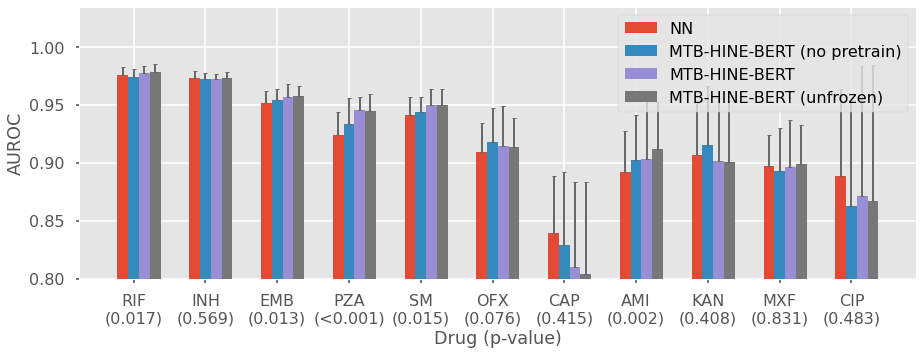

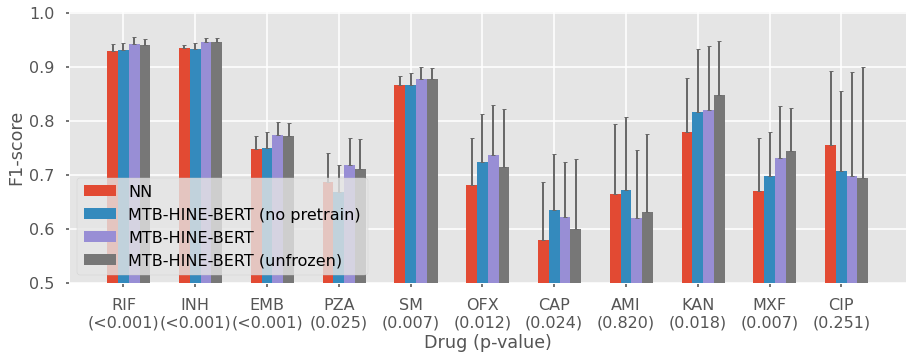

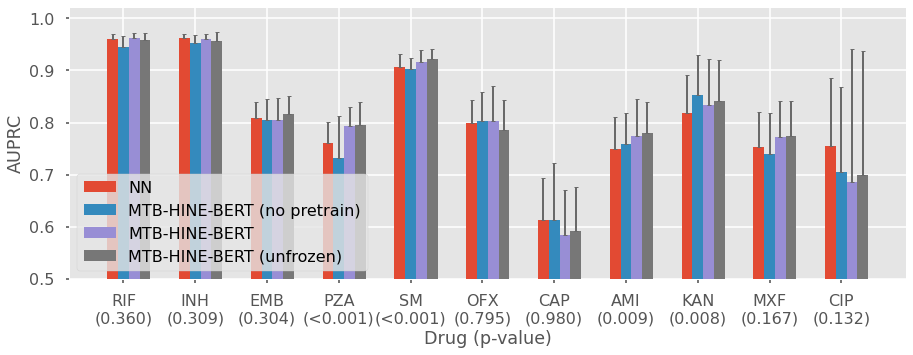

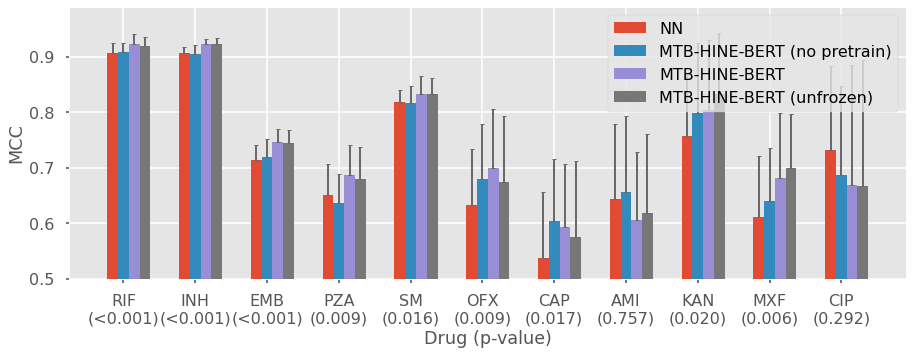

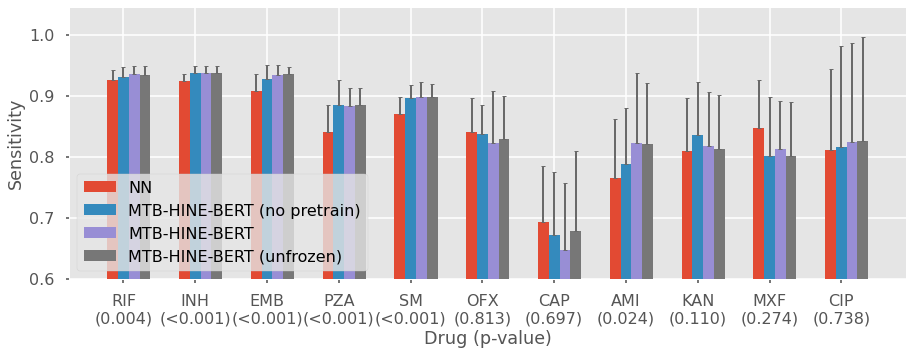

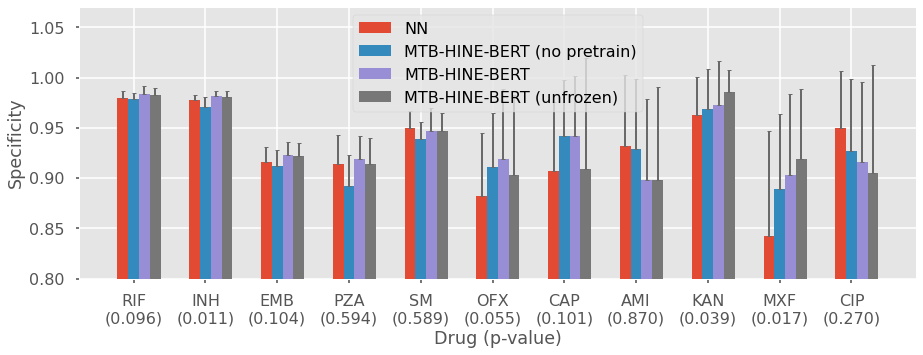

In [67]:
binaryBarPlot('Walker', 'auroc')
binaryBarPlot('Walker', 'f1')
binaryBarPlot('Walker', 'auprc')
binaryBarPlot('Walker', 'mcc')
binaryBarPlot('Walker', 'sen')
binaryBarPlot('Walker', 'spe')

In [112]:
import scipy.stats as stats
# output the results and bold the best results
def boldBestPlusPvalue(res_dict, drug, matrix, model_list):
    # calculate the p-value and add it to p_value_dict
    p_value_dict = {}
    res_list1 = res_dict[(drug, model_list[0])][matrix + '_list']
    for model in model_list[1:]:
        res_list2 = res_dict[(drug, model)][matrix + '_list']
        _, p_value = stats.ttest_rel(res_list1, res_list2)
        p_value_dict[model] = p_value

    max_value = max([round(res_dict[(drug, model)][matrix][0], 3) for model in model_list])
    res = ""
    for model in model_list:
        if math.isclose(round(res_dict[(drug, model)][matrix][0], 3), max_value):
            if model in p_value_dict and p_value_dict[model] < 0.05:
                res += f'\\textbf{{{res_dict[(drug, model)][matrix][0]:.3f}({res_dict[(drug, model)][matrix][1]:.3f})}}\hl{{*}} & '
            else: 
                res += f'\\textbf{{{res_dict[(drug, model)][matrix][0]:.3f}({res_dict[(drug, model)][matrix][1]:.3f})}} & '
        else:
            if model in p_value_dict and p_value_dict[model] < 0.05:
                res += f'{res_dict[(drug, model)][matrix][0]:.3f}({res_dict[(drug, model)][matrix][1]:.3f})\hl{{*}} & '
            else:
                res += f'{res_dict[(drug, model)][matrix][0]:.3f}({res_dict[(drug, model)][matrix][1]:.3f}) & '

    # Calculate the p-value between the first model and the best of the rest models
    res_list1 = res_dict[(drug, model_list[0])][matrix + '_list']
    mean2, std2, res_list2 = float('-inf'), float('inf'), []
    for model in model_list[1:]:
        mean, std = res_dict[(drug, model)][matrix]
        # when the mean is larger, update the best model
        if round(mean, 3) > round(mean2, 3):
            mean2 = mean
            std2 = std
            res_list2 = res_dict[(drug, model)][matrix + '_list']
        # when the mean is equal, update the best model with smaller std
        elif round(mean, 3) == round(mean2, 3) and round(std, 3) < round(std2, 3):
            mean2 = mean
            std2 = std
            res_list2 = res_dict[(drug, model)][matrix + '_list']
    _, p_value = stats.ttest_rel(res_list1, res_list2)


    res += f'\hl{{{p_value:.3f}}}& ' if p_value >= 0.001 else f'\hl{{<0.001}}& '
    res = res[:-2] + '\\\\ \n'
    return res

# Print the results to the table for latex
def printBertTable():
    dataset = 'Walker'
    drug_list = getDrugList(dataset)
    model_list = ['nn', 'bert1_no_pretrained', 'bert1', 'bert1_no_freeze']
    matrices = ['sen', 'spe', 'auroc', 'f1', 'auprc', 'mcc']
    matrix_name = {'sen': 'Sensitivity', 'spe': 'Specificity', 'f1': 'F1-score', 'auroc': 'AUROC', 'mcc': 'MCC', 'auprc': 'AUPRC'}
    res_dict = {}
    for drug in drug_list:
        for model in model_list:
            res_dict[(drug, model)] = getBinaryResults(dataset, drug, model)
    
    res = ""
    res += '\\begin{tabular}{ccccccc}\n'
    res += '\hline\n'
    res += ' & & \multicolumn{4}{c}{Model} & \\\\ \n'
    res += '\cline{3-6}\n'
    res += 'Drug & & NN & MTB-HINE-BERT (no pretrain) & MTB-HINE-BERT & MTB-HINE-BERT (no freeze) & p-value \\\\ \n'
    res += '\hline\n'
    for drug in drug_list:
        res += f'\multirow{{6}}{{*}}{{{drug_dict[drug]}}} & Sensitivity & '
        res += boldBestPlusPvalue(res_dict, drug, 'sen', model_list)
        for matrix in matrices[1:]:
            res += f'~ & {matrix_name[matrix]} & '
            res += boldBestPlusPvalue(res_dict, drug, matrix, model_list)
        res += '\hline\n'
    res += '\end{tabular}\n'
    print(res)

In [113]:
printBertTable()

\begin{tabular}{ccccccc}
\hline
 & & \multicolumn{4}{c}{Model} & \\ 
\cline{3-6}
Drug & & NN & MTB-HINE-BERT (no pretrain) & MTB-HINE-BERT & MTB-HINE-BERT (no freeze) & p-value \\ 
\hline
\multirow{6}{*}{RIF} & Sensitivity & 0.925(0.018) & 0.930(0.016) & \textbf{0.936(0.013)}\hl{*} & 0.934(0.015)\hl{*} & \hl{0.004}\\ 
~ & Specificity & 0.980(0.007) & 0.979(0.006) & \textbf{0.984(0.008)} & 0.983(0.007) & \hl{0.096}\\ 
~ & AUROC & 0.976(0.007) & 0.974(0.007) & 0.978(0.007) & \textbf{0.979(0.007)}\hl{*} & \hl{0.017}\\ 
~ & F1-score & 0.929(0.013) & 0.931(0.012) & \textbf{0.942(0.013)}\hl{*} & 0.939(0.012)\hl{*} & \hl{<0.001}\\ 
~ & AUPRC & 0.960(0.009) & 0.945(0.022)\hl{*} & \textbf{0.962(0.009)} & 0.958(0.015) & \hl{0.360}\\ 
~ & MCC & 0.908(0.017) & 0.910(0.016) & \textbf{0.924(0.018)}\hl{*} & 0.920(0.016)\hl{*} & \hl{<0.001}\\ 
\hline
\multirow{6}{*}{INH} & Sensitivity & 0.924(0.011) & 0.937(0.011)\hl{*} & 0.937(0.011)\hl{*} & \textbf{0.938(0.011)}\hl{*} & \hl{<0.001}\\ 
~ & Specificit

In [28]:
# Analysis the results of the MTB-HINE-BERT model with all other models
def binaryBarPlot(dataset, matrix):
    drug_list = getDrugList(dataset)
    # drug_list = ['INH', 'EMB', 'PZA', 'OFX', 'CAP', 'AK', 'KAN', 'MOX', 'CIP']
    model_list = ['bert1', 'bert1_no_freeze', 'lr', 'svm', 'rf', 'adaboost', 'gbt', 'nn']
    model_name = {'lr': 'LR', 'svm': 'SVM', 'rf': 'RF', 'adaboost': 'AdaBoost', 'gbt': 'GBT', 'nn': 'NN', 'bert1': 'BERT', 'bert1_no_freeze': 'BERT(unfrozen)', 'bert1_no_pretrained': 'MTB-HINE-BERT (no pretrain)'}
    matrix_name = {'sen': 'Sensitivity', 'spe': 'Specificity', 'f1': 'F1-score', 'auroc': 'AUROC', 'mcc': 'MCC', 'auprc': 'AUPRC'}

    # group bar plot
    X_axis = np.arange(len(drug_list))
    res_dict = {}
    y_min = 1
    for model in model_list:
        res_dict[model] = {'mean': [], 'std': []}
        for drug in drug_list:
            mean_value, std_value = getBinaryResults(dataset, drug, model)[matrix]
            res_dict[model]['mean'].append(mean_value)
            res_dict[model]['std'].append(std_value)
            if mean_value < y_min:
                y_min = mean_value
    # let y_min be the smallest 0.1 multiple
    y_min = int(y_min * 10) / 10

    width = 0.1
    fig, ax = plt.subplots(figsize=(20, 5))
    for i, model in enumerate(model_list):
        ax.bar(X_axis + i * width, res_dict[model]['mean'], width, label=model_name[model])
    # plot the std as error bar with lowlims=True, don't show the arrow
    for i, model in enumerate(model_list):
        _, caplines, _ = ax.errorbar(X_axis + i * width, res_dict[model]['mean'], yerr=res_dict[model]['std'], fmt='none', ecolor='dimgray', capsize=2, capthick=1, elinewidth=2, lolims=True)
        caplines[0].set_marker('_')
    
    ax.set_ylim(ymin=y_min)
    ax.set_xlabel('Drug')
    ax.set_ylabel(matrix_name[matrix])
    ax.set_xticks(X_axis + width)
    ax.set_xticklabels([drug_dict[drug] for drug in drug_list])
    ax.legend(prop = { "size": 10 })
    plt.savefig(f'../Figures/tmp_bert_{matrix}.png', bbox_inches='tight')
    plt.show()

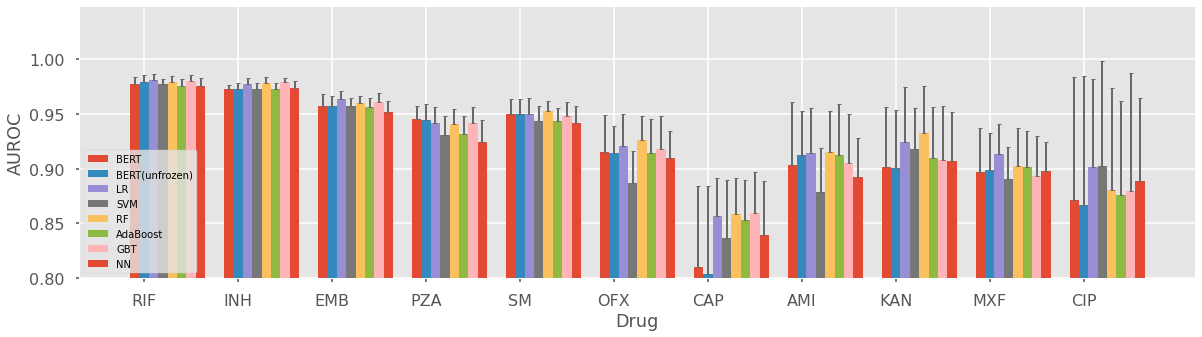

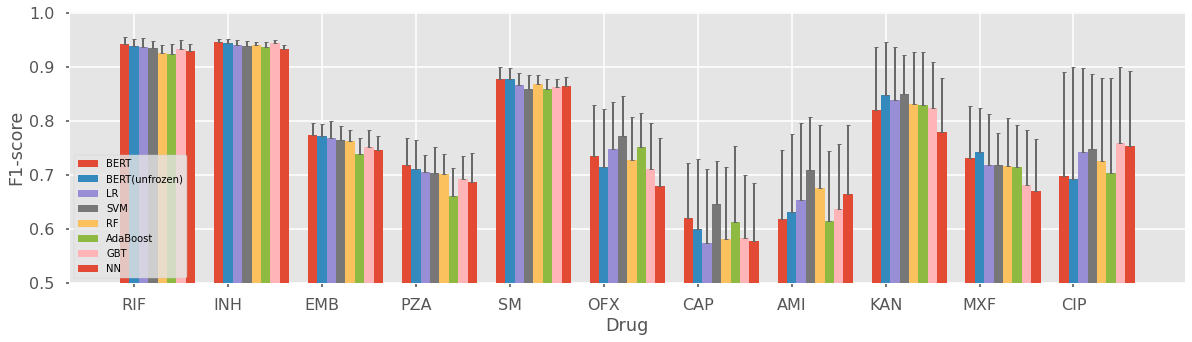

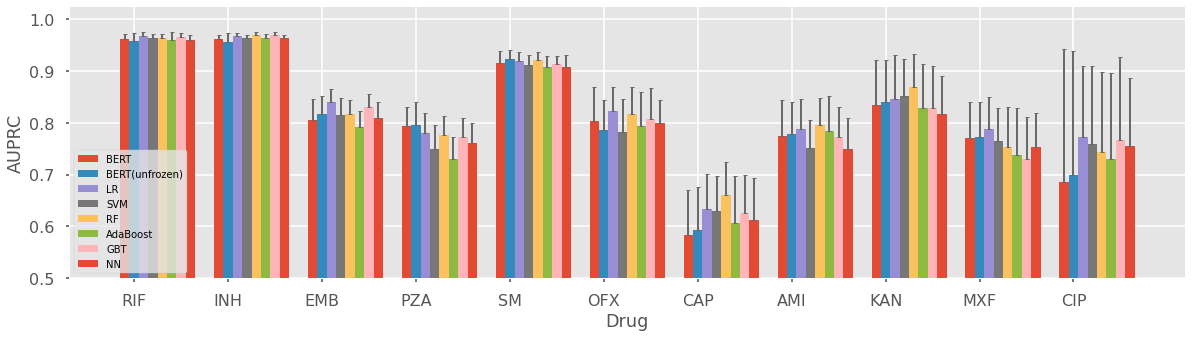

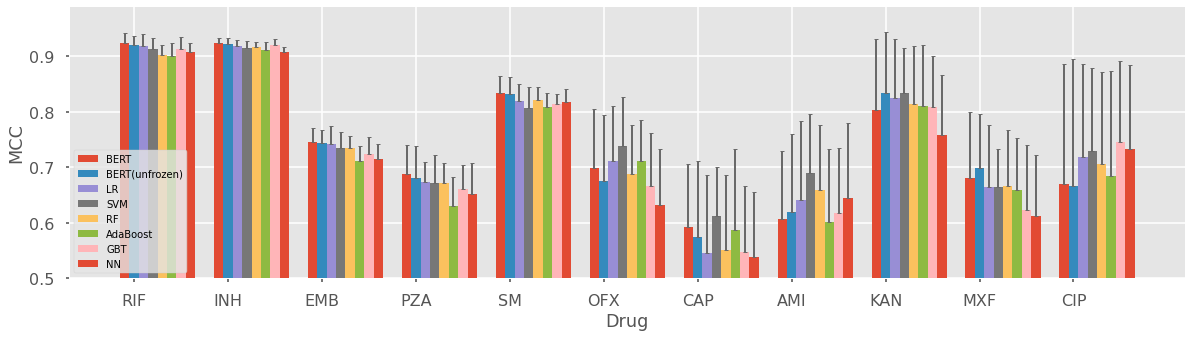

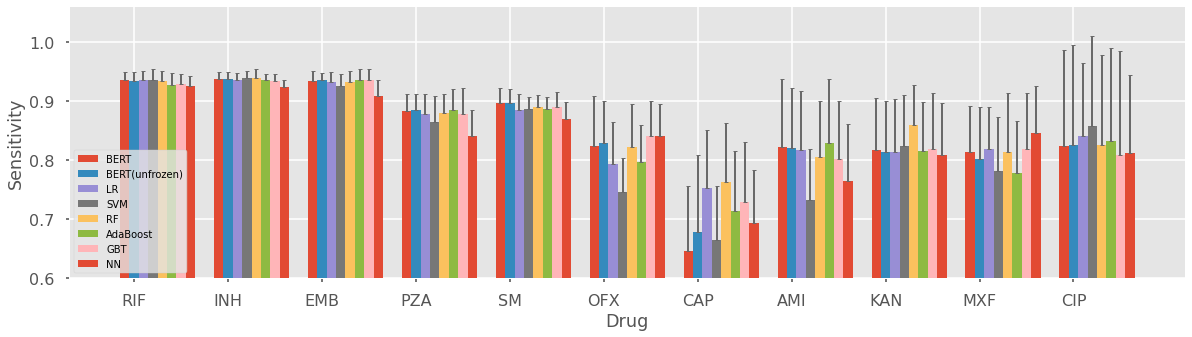

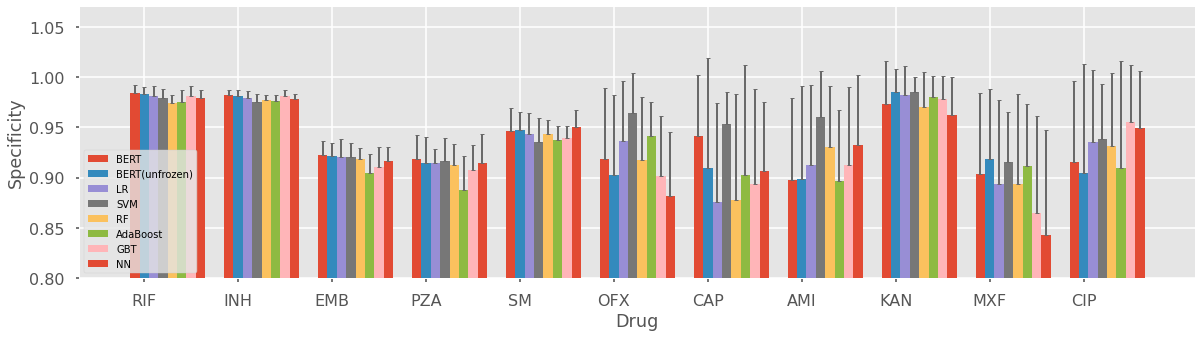

In [29]:
binaryBarPlot('Walker', 'auroc')
binaryBarPlot('Walker', 'f1')
binaryBarPlot('Walker', 'auprc')
binaryBarPlot('Walker', 'mcc')
binaryBarPlot('Walker', 'sen')
binaryBarPlot('Walker', 'spe')

In [48]:
RIF_bert_sen = getBinaryResults('Walker', 'RIF', 'bert1')['sen_list']
RIF_nn_sen = getBinaryResults('Walker', 'RIF', 'nn')['sen_list']
t_statistic, p_value = stats.ttest_rel(RIF_bert_sen, RIF_nn_sen)
print('t_statistic:', t_statistic)
print('p_value:', p_value)

t_statistic: 3.275097648283303
p_value: 0.003982487023572113


In [49]:
t_statistic, p_value = stats.ttest_ind(RIF_bert_sen, RIF_nn_sen)
print('t_statistic:', t_statistic)
print('p_value:', p_value)

t_statistic: 2.148033113338725
p_value: 0.038149484208556704


In [84]:
RIF_bert_sen = getBinaryResults('Walker', 'RIF', 'bert1')['sen_list']
RIF_nn_sen = getBinaryResults('Walker', 'RIF', 'nn')['sen_list']
# calculate the difference between the two models
diff = np.array(RIF_bert_sen) - np.array(RIF_nn_sen)
# calculate the mean and var of the difference
mean_diff = np.mean(diff)
var_diff = np.var(diff, ddof=1)
# calculate the t-statistic
t_statistic = mean_diff / (np.sqrt(var_diff/len(diff)))
# calculate the degrees of freedom
df = len(diff) - 1
# calculate the two-tailed p-value
p_value = 2 * (1 - stats.t.cdf(t_statistic, df))

print('mean_diff:', mean_diff)
print('var_diff:', std_diff**2)
print('var:', np.var(diff, ddof=1))
print('t_statistic:', t_statistic)
print('p_value:', p_value)

mean_diff: 0.010999198350893264
var_diff: 0.0002143024629135646
var: 0.0002255815399090154
t_statistic: 3.275097648283303
p_value: 0.003982487023572068


In [80]:
a = np.array(getBinaryResults('Walker', 'RIF', 'bert1')['sen_list'])
b = np.array(getBinaryResults('Walker', 'RIF', 'nn')['sen_list'])

axis = 0
n = a.shape[0]
df = n - 1
d = (a - b).astype(np.float64)
v = np.var(d, axis, ddof=1)
dm = np.mean(d, axis)
denom = np.sqrt(v / n)
t = np.divide(dm, denom)
print('mean:', dm)
print('v:', v)
print('t_statistic:', t)

mean: 0.010999198350893264
v: 0.0002255815399090154
t_statistic: 3.275097648283303
